In [326]:
# importing packages
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import re
import random
from sklearn.model_selection import train_test_split
from sklearn.decomposition import TruncatedSVD
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, classification_report
from sklearn.model_selection import GridSearchCV
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization
from tensorflow.keras.regularizers import l2
from tensorflow.keras.optimizers import Adam
from sklearn.metrics import accuracy_score
from sklearn.base import BaseEstimator, ClassifierMixin
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.utils import to_categorical
import warnings
from sklearn.exceptions import UndefinedMetricWarning
warnings.filterwarnings("ignore", category=UndefinedMetricWarning)
import nltk
from nltk.corpus import stopwords
nltk.download('punkt')
nltk.download('stopwords')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [113]:
# using GPU to enable faster calculation in future steps
import tensorflow as tf
import numpy as np

# Check GPU availability
print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))

Num GPUs Available:  1


In [114]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [115]:
import pandas as pd

data_file = '/content/drive/My Drive/HW1/amazon_reviews.csv'
# df0 = pd.read_csv(data_file, sep='\t', compression='gzip', nrows=2_000_000)
df = pd.read_csv(data_file)

In [116]:
# given review data
df.head()

,overall,reviewText
0,4,No issues.
1,5,"Purchased this for my device, it worked as adv..."
2,4,it works as expected. I should have sprung for...
3,5,This think has worked out great.Had a diff. br...
4,5,"Bought it with Retail Packaging, arrived legit..."


**Solving as a Multi-Class Classification Problem**

**Task 1: Extracting features**

**1. Data preparation**

**1) Data preprocessing**

Implementing a class based data preprocessing - to remove punctuations, urls, stopwords, numbers and finally making it into lower case and creating tokens

In [194]:
class Preprocess:
    def __init__(self, corpus):
        self.corpus = corpus

    def lowercase(self):
        self.corpus = self.corpus.lower()
#         print(self.corpus)

    def remove_punct(self):
        self.corpus = re.sub(r'[^\w\s]',"", self.corpus)
#         print(self.corpus)

    def remove_stopwords(self):
        stop_words = set(stopwords.words('english'))
        corpus_words = self.corpus.split()
        self.corpus = ' '.join([x for x in corpus_words if x not in stop_words])
#         print(self.corpus)

    def remove_numbers(self):
        self.corpus = re.sub(r'\d',"", self.corpus)
        self.corpus = ' '.join(self.corpus.split())
#         print(self.corpus)

    def remove_urls(self):
      url_pattern = r'https?://(?:www\.)?\S+|www\.\S+'
      self.corpus = re.sub(url_pattern, '', self.corpus)

    def tokenize(self):
        self.corpus = nltk.word_tokenize(self.corpus)
#         print(self.corpus)

**Checking data quality**

In [195]:
print('\nTotal number of null entries in the Review: ',df['reviewText'].isnull().sum())
print('\nEntry that has null review\n')
print(df[df['reviewText'].isnull()])
df.dropna(subset=['reviewText'], inplace=True)
print('\nTotal number of null entries after dropping null value: ',df['reviewText'].isnull().sum())


Total number of null entries in the Review:  0

Entry that has null review

Empty DataFrame
Columns: [overall, reviewText, processed_reviewText]
Index: []

Total number of null entries after dropping null value:  0


In [296]:
# implementing the preprocessing steps
processed_text = []

for index, text in enumerate(df['reviewText']):
    p = Preprocess(text)
    p.remove_urls()
    p.remove_punct()
    p.remove_numbers()
    p.lowercase()
    p.remove_stopwords()
    p.tokenize()

    processed_text.append(p.corpus)

In [297]:
# adding a column to the original dataset which contains the preprocessed data
df['processed_reviewText'] = processed_text

In [298]:
# creating a separate dataframe with the required features
df_prep = df[['overall','processed_reviewText']]

In [299]:
# first five rows of the new dataframe
df_prep.head()

,overall,processed_reviewText
0,4,[issues]
1,5,"[purchased, device, worked, advertised, never,..."
2,4,"[works, expected, sprung, higher, capacity, th..."
3,5,"[think, worked, greathad, diff, bran, gb, card..."
4,5,"[bought, retail, packaging, arrived, legit, or..."


**2) Data split**

In [200]:
[x_train, x_test, y_train, y_test] = train_test_split(df_prep['processed_reviewText'], df_prep['overall'], test_size=0.2, random_state=1234)

In [201]:
[x_val, x_test, y_val, y_test] = train_test_split(x_test, y_test, test_size=0.5, random_state=1234)

**3) Data statistics**

**Number of data samples in train/validation/test set**

In [202]:
print('\nx_train length\t:',len(x_train))
print('\nx_test length\t:',len(x_test))
print('\nx_val length\t:',len(x_val))
print('\ny_train length\t:',len(y_train))
print('\ny_test length\t:',len(y_test))
print('\ny_val length\t:',len(y_val))


x_train length	: 3931

x_test length	: 492

x_val length	: 491

y_train length	: 3931

y_test length	: 492

y_val length	: 491


**Number of Tokens**

In [203]:
min_no_tokens = df_prep['processed_reviewText'].apply(len).min()
min_no_tokens_df = df_prep.loc[df['processed_reviewText'].apply(len) == df_prep['processed_reviewText'].apply(len).min()]

mean_no_tokens = df_prep['processed_reviewText'].apply(len).mean()

max_no_tokens = df_prep['processed_reviewText'].apply(len).max()
max_no_tokens_df = df_prep[df_prep['processed_reviewText'].apply(len) == df_prep['processed_reviewText'].apply(len).max()]

In [204]:
print('\nMinimum number of tokens\t:', min_no_tokens)
print('\nMean number of tokens\t\t:', mean_no_tokens)
print('\nMaximum number of tokens\t:', max_no_tokens)


Minimum number of tokens	: 1

Mean number of tokens		: 25.4029304029304

Maximum number of tokens	: 781


In [205]:
# Datapoint that has the minimum number of tokens
min_no_tokens_df

,overall,processed_reviewText
0,4,[issues]
705,5,[yes]
1452,4,[nice]
1666,5,[designed]
2496,5,[yes]
2560,5,[supposed]
2856,5,[job]
3013,5,[problems]
3234,5,[good]
3487,5,[excelent]


In [206]:
# Datapoint that has the maximum number of tokens
max_no_tokens_df

,overall,processed_reviewText
4212,1,"[note, please, read, last, update, scroll, bot..."


**Number of positive/negative reviews in train/validation/test set**

In [300]:
positive_reviews_train = df_prep[df_prep['overall'] == 5]

In [208]:
positive_reviews_train

,overall,processed_reviewText
1,5,"[purchased, device, worked, advertised, never,..."
3,5,"[think, worked, greathad, diff, bran, gb, card..."
4,5,"[bought, retail, packaging, arrived, legit, or..."
5,5,"[mini, storage, doesnt, anything, else, suppos..."
6,5,"[phone, never, skips, beat, file, transfers, s..."
...,...,...
4909,5,"[bought, stretch, capability, lg, gpad, gpe, t..."
4911,5,"[used, extending, capabilities, samsung, galax..."
4912,5,"[great, card, fast, reliable, comes, optional,..."
4913,5,"[good, amount, space, stuff, want, fits, gopro..."


In [209]:
#For training set
print('\nReview Categorization for Training set: \n')
print(y_train.value_counts())

#For va\nlidation set
print('\nReview Categorization for Validation set: \n')
print(y_val.value_counts())

#For training set
print('\nReview Categorization for Test set: \n')
print(y_test.value_counts())


Review Categorization for Training set: 

5    3145
4     420
1     190
3     113
2      63
Name: overall, dtype: int64

Review Categorization for Validation set: 

5    384
4     54
1     26
3     17
2     10
Name: overall, dtype: int64

Review Categorization for Test set: 

5    392
4     53
1     28
3     12
2      7
Name: overall, dtype: int64


**2. Representation of Texts: word vectors**

**1) Count-based word vectors with co-occurrence matrix**

In [210]:
# a. function named get_vacab(corpus) that returns corpus_words
def get_vocab(corpus):
    corpus_words = []
    corpus_words = sorted({word for text in corpus for word in text if word not in corpus_words})
    return corpus_words

In [211]:
corpus_words = get_vocab(df_prep['processed_reviewText'])
print('\nNumber of distinct words in the corpus : ', len(corpus_words))
print('\nDistinct words used in the review corpus:\n', corpus_words[:100])


Number of distinct words in the corpus :  9697

Distinct words used in the review corpus:
 ['_', '_______', 'aac', 'aas', 'aba', 'abdroid', 'abilities', 'ability', 'able', 'aboutgood', 'abouti', 'abouttherehere', 'aboutto', 'abovei', 'abroad', 'abruptly', 'absolute', 'absolutely', 'abt', 'abuse', 'abused', 'abysmal', 'accdientally', 'accept', 'acceptable', 'acceptably', 'accepted', 'accepting', 'accepts', 'access', 'accessed', 'accesses', 'accessible', 'accessing', 'accessories', 'accessory', 'accessoryalternative', 'accident', 'accidentally', 'accidently', 'acclimated', 'accolades', 'accommodate', 'accomplish', 'accord', 'according', 'accordingly', 'account', 'accros', 'accurate', 'accuratei', 'accuratethe', 'ace', 'acer', 'acess', 'acheive', 'achieve', 'achieved', 'achievedusing', 'achieves', 'acitve', 'acknowledge', 'acknowledged', 'acontourroam', 'acquire', 'acquired', 'acronis', 'acronyms', 'across', 'act', 'acting', 'action', 'actioncam', 'activating', 'active', 'activity', 'act

In [212]:
# b. function compute_co_occurrence_matrix(corpus,window_size=4) that returns both M and word2index
def compute_co_occurrence_matrix(corpus, window_size=4):
    word2index = {word: index for index, word in enumerate(corpus)}

    M = np.zeros((len(word2index),len(word2index)), dtype = np.int32)

    for i, target in enumerate(corpus):
        start = max(0, i - window_size)
        end = min(len(corpus), i + window_size + 1)

        for j in range(start, end):
            if i != j and corpus[j] in word2index:
                M[word2index[target]][word2index[corpus[j]]] += 1

    return M, word2index


In [213]:
M, word2index = compute_co_occurrence_matrix(corpus_words)

In [214]:
print('\nThe shape of co-occurence matrix M:\n',M.shape)


The shape of co-occurence matrix M:
 (9697, 9697)


In [215]:
print('\nThe co-occurence matrix M:\n',M)


The co-occurence matrix M:
 [[0 1 1 ... 0 0 0]
 [1 0 1 ... 0 0 0]
 [1 1 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 1 1]
 [0 0 0 ... 1 0 1]
 [0 0 0 ... 1 1 0]]


In [301]:
print('\nThe word2index dictionary:\n',word2index)


The word2index dictionary:
 {'_': 0, '_______': 1, 'aac': 2, 'aas': 3, 'aba': 4, 'abdroid': 5, 'abilities': 6, 'ability': 7, 'able': 8, 'aboutgood': 9, 'abouti': 10, 'abouttherehere': 11, 'aboutto': 12, 'abovei': 13, 'abroad': 14, 'abruptly': 15, 'absolute': 16, 'absolutely': 17, 'abt': 18, 'abuse': 19, 'abused': 20, 'abysmal': 21, 'accdientally': 22, 'accept': 23, 'acceptable': 24, 'acceptably': 25, 'accepted': 26, 'accepting': 27, 'accepts': 28, 'access': 29, 'accessed': 30, 'accesses': 31, 'accessible': 32, 'accessing': 33, 'accessories': 34, 'accessory': 35, 'accessoryalternative': 36, 'accident': 37, 'accidentally': 38, 'accidently': 39, 'acclimated': 40, 'accolades': 41, 'accommodate': 42, 'accomplish': 43, 'accord': 44, 'according': 45, 'accordingly': 46, 'account': 47, 'accros': 48, 'accurate': 49, 'accuratei': 50, 'accuratethe': 51, 'ace': 52, 'acer': 53, 'acess': 54, 'acheive': 55, 'achieve': 56, 'achieved': 57, 'achievedusing': 58, 'achieves': 59, 'acitve': 60, 'acknowledge

In [217]:
# c. function named reduce_to_k_dim(M) to perform dimensionality reduction on the matrix M
def reduce_to_k_dim(M, k=2):
    svd = TruncatedSVD(n_components=k, n_iter=10)
    M_dim_red = svd.fit_transform(M)

    return M_dim_red

In [218]:
M_reduced = reduce_to_k_dim(M, k=2)

In [219]:
print('\nThe shape of co-occurence matrix M_reduced:\n',M_reduced.shape)
print('\nThe co-occurence matrix M_reduced:\n',M_reduced)


The shape of co-occurence matrix M_reduced:
 (9697, 2)

The co-occurence matrix M_reduced:
 [[-0.00112376 -0.02817315]
 [-0.00135669 -0.03787246]
 [-0.00153206 -0.04887801]
 ...
 [ 0.01324706 -0.02104999]
 [ 0.01039436 -0.01639838]
 [ 0.00782031 -0.01225845]]


In [220]:
# d. function named plot_embeddings(M_reduced, word2index, words_to_plot) to get scatterplot of embeddings
def plot_embeddings(M_reduced, word2index, words_to_plot):
    indices = [word2index[word] for word in words_to_plot]
    embeddings = M_reduced[indices]

    plt.figure(figsize=(12,10))
    plt.scatter(embeddings[:,0], embeddings[:,1], c='purple', marker = 's')

    for i, word in enumerate(words_to_plot):
        plt.annotate(word, (embeddings[i,0], embeddings[i,1]), fontsize=12)

    plt.xlabel('Dimension 1', fontsize=12)
    plt.ylabel('Dimension 2', fontsize=12)
    plt.title('Word Embeddings Scatterplot', fontsize=14)
    plt.grid(True)
    plt.show()

    return

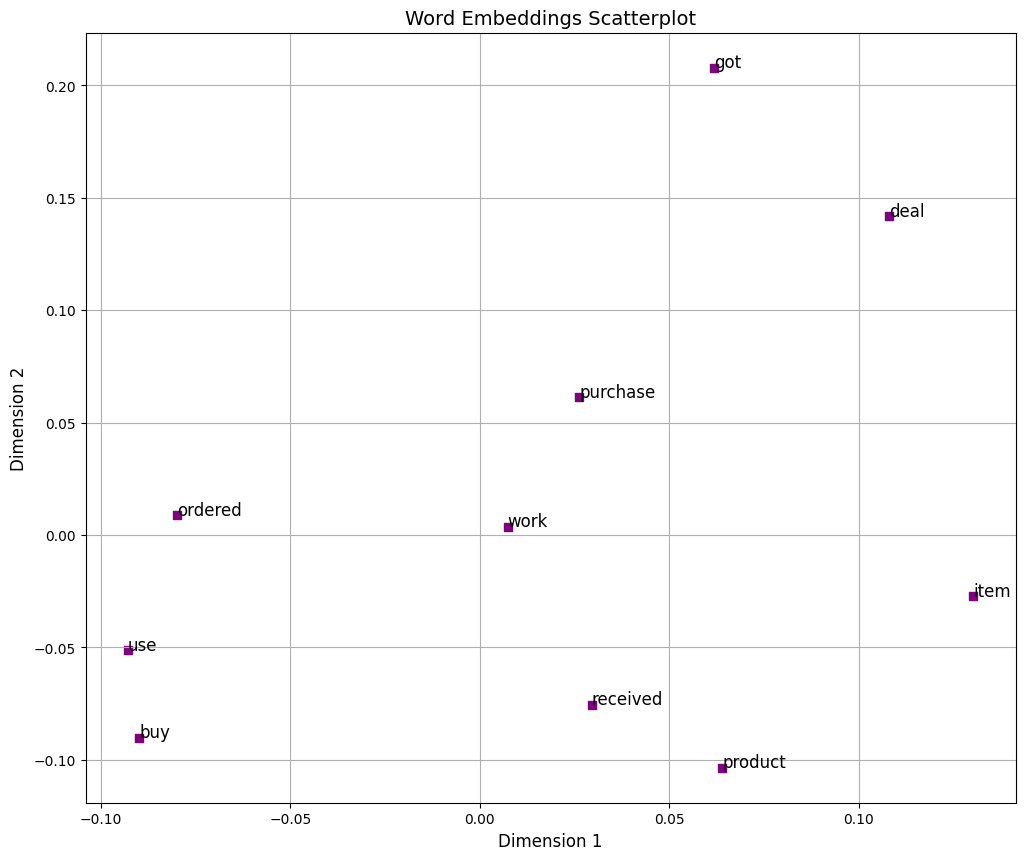

In [221]:
words_to_plot = ['purchase', 'buy', 'work', 'got', 'ordered', 'received', 'product', 'item', 'deal', 'use']
plot_embeddings(M_reduced, word2index, words_to_plot)

**2) Prediction-based word vectors from Glove**

In [224]:
# a. function load_embedding_model() to load the GloVe embeddings
import gensim.downloader as api

def load_embedding_model():
    wv_from_bin = api.load("glove-wiki-gigaword-200")
    print("Loaded vocab size %i" % len(list(wv_from_bin.index_to_key)))
    return wv_from_bin

wv_from_bin = load_embedding_model()

Loaded vocab size 400000


In [225]:
# b. function get_matrix_of_vectors(wv_from_bin, required_words)
def get_matrix_of_vectors(wv_from_bin, required_words):
    word2ind = {}
    M = []
    curInd = 0
    for w in required_words:
        try:
            M.append(wv_from_bin.get_vector(w))
            word2ind[w] = curInd
            curInd += 1
        except KeyError:
            continue
    M = np.stack(M)
    return M, word2ind

In [226]:
required_words = corpus_words
M_glove, word2index_glove = get_matrix_of_vectors(wv_from_bin, required_words)

In [227]:
M_glove

array([[ 0.030697 ,  0.74523  , -0.047813 , ...,  0.13697  ,  0.16943  ,
         0.29801  ],
       [ 0.24235  ,  0.40955  ,  0.80167  , ...,  0.9893   , -0.26872  ,
        -0.25614  ],
       [ 0.22586  ,  0.055649 ,  0.28368  , ..., -0.28357  ,  0.36353  ,
        -0.8737   ],
       ...,
       [-0.55794  , -0.15971  ,  0.068403 , ..., -0.15635  ,  0.11359  ,
         0.47554  ],
       [ 0.4385   , -0.64002  , -0.70505  , ...,  0.0046388, -0.0224   ,
         0.13018  ],
       [-0.35548  ,  0.22649  , -0.37089  , ..., -0.062321 ,  0.19923  ,
        -0.15657  ]], dtype=float32)

In [228]:
word2index_glove

{'_': 0,
 '_______': 1,
 'aac': 2,
 'aas': 3,
 'aba': 4,
 'abilities': 5,
 'ability': 6,
 'able': 7,
 'abroad': 8,
 'abruptly': 9,
 'absolute': 10,
 'absolutely': 11,
 'abt': 12,
 'abuse': 13,
 'abused': 14,
 'abysmal': 15,
 'accept': 16,
 'acceptable': 17,
 'acceptably': 18,
 'accepted': 19,
 'accepting': 20,
 'accepts': 21,
 'access': 22,
 'accessed': 23,
 'accesses': 24,
 'accessible': 25,
 'accessing': 26,
 'accessories': 27,
 'accessory': 28,
 'accident': 29,
 'accidentally': 30,
 'accidently': 31,
 'acclimated': 32,
 'accolades': 33,
 'accommodate': 34,
 'accomplish': 35,
 'accord': 36,
 'according': 37,
 'accordingly': 38,
 'account': 39,
 'accurate': 40,
 'ace': 41,
 'acer': 42,
 'acess': 43,
 'acheive': 44,
 'achieve': 45,
 'achieved': 46,
 'achieves': 47,
 'acknowledge': 48,
 'acknowledged': 49,
 'acquire': 50,
 'acquired': 51,
 'acronyms': 52,
 'across': 53,
 'act': 54,
 'acting': 55,
 'action': 56,
 'activating': 57,
 'active': 58,
 'activity': 59,
 'acts': 60,
 'actual': 6

In [229]:
# c. Use the function reduce_to_k_dim() to reduce the vectors to 2 dimension
M_reduced_glove = reduce_to_k_dim(M_glove, k=2)
M_reduced_glove

array([[ 3.9463973, -0.4825527],
       [-1.2189243,  1.7460573],
       [-0.6652177,  1.9017084],
       ...,
       [-1.3808935,  1.2354888],
       [-0.9839458,  0.7045804],
       [-0.1686201,  2.9487126]], dtype=float32)

In [302]:
# d. Use the plot_embeddings function to get the plot for the same set of words in 1)d. Compare the differences of the plot in 1)d and 2)d, provide some analysis, and describe your findings

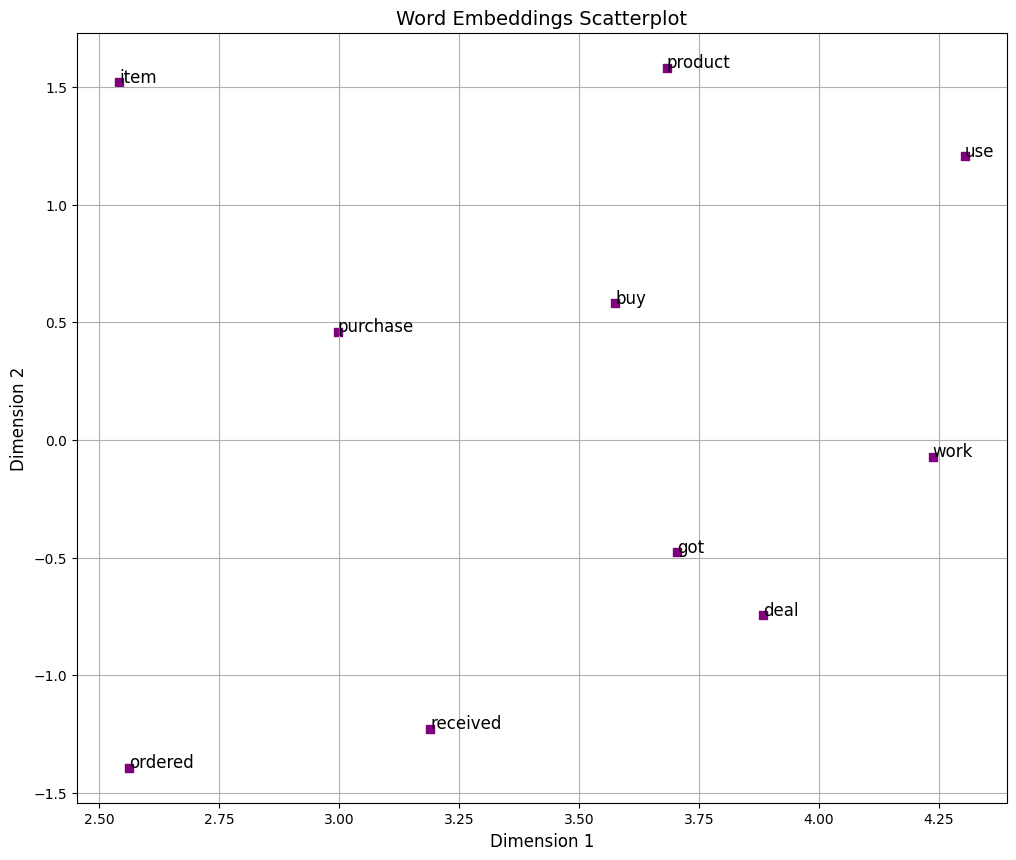

In [231]:
words_to_plot = ['purchase', 'buy', 'work', 'got', 'ordered', 'received', 'product', 'item', 'deal', 'use']
plot_embeddings(M_reduced_glove, word2index_glove, words_to_plot)

In [232]:
# plt.figure(figsize=(6,6))
# plot_embeddings(M_reduced, word2index, words_to_plot)
# plt.show()

**Analysis**

1. Between the two plots in 1d and 2d, the embeddings generated in 1d are specific to the defined corpus, whereas in 2d, the embeddings are generated based on a large corpus of words. This makes the second one more generic pertaining to a general context, whereas the first one is more specific to its own corpus and this might not be suited to be applied to a general context, ie, other corpus.
2. In the first plot, since there is a semantic relationship between the words since it belongs to the corpus, the word embeddings are closer together. While the same words have a different relationship when using the GloVe based embeddings - this shows a farther relationship as the words are a part of a larger corpus. This indicates context dependencies.

**Task 2: Sentiment Classification Algorithms**

**3. Perform sentiment analysis with classification**

**1) Review embeddings**

In [234]:
M_reduced_128 = reduce_to_k_dim(M, 128)

In [235]:
M_reduced_128.shape

(9697, 128)

In [236]:
def review_embeddings(reviews, M, word2index):
    review_embeddings = []
    for review in reviews:
        review_word_indices = [word2index[word] for word in review if word in word2index]
        if len(review_word_indices)>0:
            mean_embedding_value = np.mean(M[review_word_indices], axis=0)
            review_embeddings.append(mean_embedding_value)
    return np.array(review_embeddings)

In [332]:
train_review_embeddings = review_embeddings(x_train, M_reduced_128, word2index)
valid_review_embeddings = review_embeddings(x_val, M_reduced_128, word2index)
test_review_embeddings = review_embeddings(x_test, M_reduced_128, word2index)

In [331]:
train_review_embeddings

array([[ 1.21820073e-02, -1.54748563e-02,  2.74927779e-02, ...,
        -2.01185015e-02,  1.09985889e-05, -1.99050721e-02],
       [-1.11714115e-02,  2.31783563e-02,  3.72613212e-02, ...,
        -1.20400277e-04,  2.35149084e-02,  4.65155189e-02],
       [ 1.49294251e-02,  6.15555337e-02,  8.12404981e-03, ...,
         4.31725441e-03, -1.37903208e-03, -1.32289516e-02],
       ...,
       [ 4.13576674e-03,  4.88116033e-03,  5.59963922e-03, ...,
        -1.45919769e-02, -1.86499528e-02, -2.49238605e-02],
       [ 4.76097045e-03,  2.93801337e-02, -2.46521649e-03, ...,
        -2.02245549e-02, -1.10124283e-02,  1.59745648e-02],
       [ 3.58408425e-02,  4.29365585e-02, -4.01637404e-03, ...,
        -4.35058555e-02,  1.49390863e-03,  1.41108537e-02]])

**2) Models**

**Logistic Regression Model**

In [334]:
log_reg_model = LogisticRegression(penalty='l2', solver='lbfgs', max_iter=10000)
log_reg_model.fit(train_review_embeddings, y_train)

LogisticRegression(max_iter=10000)

In [335]:
# predicted values for each class
log_reg_model_pred = log_reg_model.predict(test_review_embeddings)

# Calculate metrics
log_reg_model_accuracy = accuracy_score(y_test, log_reg_model_pred)
log_reg_model_precision = precision_score(y_test, log_reg_model_pred, average='weighted')
log_reg_model_recall = recall_score(y_test, log_reg_model_pred, average='weighted')
log_reg_model_f1 = f1_score(y_test, log_reg_model_pred, average='weighted')

In [336]:
# predicted probabilities for each class
log_reg_model_pred_probs = log_reg_model.predict_proba(test_review_embeddings)

# Calculate ROC AUC score
log_reg_model_auc_ovo = roc_auc_score(y_test, log_reg_model_pred_probs, average='weighted', multi_class='ovo')
log_reg_model_auc_ovr = roc_auc_score(y_test, log_reg_model_pred_probs, average='weighted', multi_class='ovr')

# Calculate other metrics
log_reg_model_accuracy = accuracy_score(y_test, log_reg_model_pred)
log_reg_model_precision = precision_score(y_test, log_reg_model_pred, average='weighted')
log_reg_model_recall = recall_score(y_test, log_reg_model_pred, average='weighted')
log_reg_model_f1 = f1_score(y_test, log_reg_model_pred, average='weighted')

**3) Evaluation**

In [344]:
# a.
print("Logistic Regression Metrics:")
print("Accuracy:", log_reg_model_accuracy)
print("Precision:", log_reg_model_precision)
print("Recall:", log_reg_model_recall)
print("F1-score:", log_reg_model_f1)
# print("AUC:", log_reg_model_auc_ovo, log_reg_model_auc_ovr)

Logistic Regression Metrics:
Accuracy: 0.7967479674796748
Precision: 0.6348073236829929
Recall: 0.7967479674796748
F1-score: 0.7066181069050509


In [338]:
print("Logistic Regression Metrics based on predicted probabilities for each class:")
print("Accuracy:", log_reg_model_accuracy)
print("Precision:", log_reg_model_precision)
print("Recall:", log_reg_model_recall)
print("F1-score:", log_reg_model_f1)
print("AUC:", log_reg_model_auc_ovo, log_reg_model_auc_ovr)

Logistic Regression Metrics based on predicted probabilities for each class:
Accuracy: 0.7967479674796748
Precision: 0.6348073236829929
Recall: 0.7967479674796748
F1-score: 0.7066181069050509
AUC: 0.7508986641807359 0.6989968077046784


**Neural Network Model**

In [339]:
# function to create the neural network model for multi-class classification
def create_nn_model(learning_rate=0.0001, batch_size=64, reg_strength=0.01, num_classes=5):
    model = Sequential([
        Dense(256, activation='relu', input_shape=(128,), kernel_regularizer=l2(reg_strength)),
        BatchNormalization(),
        Dropout(0.5),
        Dense(128, activation='relu', kernel_regularizer=l2(reg_strength)),
        BatchNormalization(),
        Dropout(0.5),
        Dense(64, activation='relu', kernel_regularizer=l2(reg_strength)),
        # softmax activation for multi-class classification problem
        Dense(num_classes, activation='softmax')
    ])
    optimizer = Adam(learning_rate=learning_rate)
    model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])
    return model

# custom estimator class for scikit-learn compatibility for multi-class classification problem
class CustomKerasClassifier(BaseEstimator, ClassifierMixin):
    def __init__(self, learning_rate=0.001, batch_size=64, reg_strength=0.01, epochs=10, num_classes=5):
        self.learning_rate = learning_rate
        self.batch_size = batch_size
        self.reg_strength = reg_strength
        self.epochs = epochs
        self.num_classes = num_classes

    def fit(self, X, y):
        self.label_encoder = LabelEncoder()
        y_encoded = self.label_encoder.fit_transform(y)
        y_categorical = to_categorical(y_encoded, num_classes=self.num_classes)

        self.model = create_nn_model(learning_rate=self.learning_rate, batch_size=self.batch_size, reg_strength=self.reg_strength, num_classes=self.num_classes)
        self.model.fit(X, y_categorical, epochs=self.epochs, batch_size=self.batch_size, verbose=0)
        return self

    def predict(self, X):
        predictions = self.model.predict(X)
        y_pred_encoded = np.argmax(predictions, axis=1)
        return self.label_encoder.inverse_transform(y_pred_encoded)

# actual number of classes
num_actual_classes = len(np.unique(y_train))

param_grid = {
    'learning_rate': [0.0001, 0.001, 0.01],
    'batch_size': [32, 64, 128],
    'reg_strength': [0.001, 0.01, 0.1],
    'num_classes': [num_actual_classes]
}

nn_model = CustomKerasClassifier()

grid = GridSearchCV(estimator=nn_model, param_grid=param_grid, cv=3, scoring='accuracy', verbose=1)

grid_result = grid.fit(train_review_embeddings, y_train)

print("Best Hyperparameters: ", grid_result.best_params_)
print("Best Accuracy: ", grid_result.best_score_)

best_model = grid_result.best_estimator_
test_predictions = best_model.predict(test_review_embeddings)
test_accuracy = accuracy_score(y_test, test_predictions)
print("Test Accuracy with Best Model:", test_accuracy)


Fitting 3 folds for each of 27 candidates, totalling 81 fits
41/41 [==============================] - 0s 2ms/step
Best Hyperparameters:  {'batch_size': 32, 'learning_rate': 0.001, 'num_classes': 5, 'reg_strength': 0.001}
Best Accuracy:  0.8013233104888563
16/16 [==============================] - 0s 2ms/step
Test Accuracy with Best Model: 0.7886178861788617


In [342]:
print("Test Accuracy with Best Model:", test_accuracy)

Test Accuracy with Best Model: 0.7886178861788617


**3) Evaluation**

In [343]:
# a.
# accuracy
test_accuracy = accuracy_score(y_test, test_predictions)
print("Test Accuracy with Best Model:", test_accuracy)

# precision
test_precision = precision_score(y_test, test_predictions, average='macro')
print("Test Precision with Best Model:", test_precision)

# recall
test_recall = recall_score(y_test, test_predictions, average='macro')
print("Test Recall with Best Model:", test_recall)

# F1-score
test_f1 = f1_score(y_test, test_predictions, average='macro')
print("Test F1-Score with Best Model:", test_f1,end='\n\n\n')

# classification report
class_report = classification_report(y_test, test_predictions)
print("Classification Report:\n", class_report,end='\n\n\n')

# confusion matrix
conf_matrix = confusion_matrix(y_test, test_predictions)
print("Confusion Matrix:\n", conf_matrix,end='\n\n')

Test Accuracy with Best Model: 0.7886178861788617
Test Precision with Best Model: 0.22857142857142856
Test Recall with Best Model: 0.2841836734693878
Test F1-Score with Best Model: 0.2524329826942654


Classification Report:
               precision    recall  f1-score   support

           1       0.31      0.46      0.37        28
           2       0.00      0.00      0.00         7
           3       0.00      0.00      0.00        12
           4       0.00      0.00      0.00        53
           5       0.83      0.96      0.89       392

    accuracy                           0.79       492
   macro avg       0.23      0.28      0.25       492
weighted avg       0.68      0.79      0.73       492



Confusion Matrix:
 [[ 13   0   0   0  15]
 [  5   0   0   0   2]
 [  4   0   0   0   8]
 [  3   0   0   0  50]
 [ 17   0   0   0 375]]



b.

The evaluation results from both the models are :

1. Logistic Regression Metrics:

    *   Accuracy: 0.7967
    *   Precision: 0.6348
    *   Recall: 0.7967
    *   F1-score: 0.7066

2. Neural Network Metrics:

    *  Test Accuracy: 0.7886
    *  Test Precision: 0.2285
    *  Test Recall: 0.2842
    *  Test F1-Score: 0.2524

Comparing the performance of both the models,
1.   Even though both the models have similar accuracy, the difference can be noted mainly in the other metrics.
2.   Logistic regression model has a higher precision compared to that of the neural network model. The Logistic Regression model is better at avoiding false positives.
3.   Logistic regression model also has a higher recall compared to that of the neural network model. The Logistic Regression model is better at capturing a higher percentage of positive cases.
4.   Logistic regression model again has a higher f1 score compared to that of the neural network model. This is the indication that the logistic regression model has a better balance between precision and recall.

In summary, the logistic regression model outperforms the neural network model in this multi-class classification problem.



**References**


1.   https://scikit-learn.org/
2.   https://web.stanford.edu/class/cs224n/assignments/a1_preview/exploring_word_vectors.html
3.   https://www.nltk.org/book/ch02.html
4.   https://web.stanford.edu/~jurafsky/slp3/6.pdf
5.   https://davetang.org/file/Singular_Value_Decomposition_Tutorial.pdf
6.   https://miroslavtushev.medium.com/faster-word-co-occurrence-calculation-in-large-document-corpus-eeac86543d8a
7.   https://towardsdatascience.com/machine-learning-word-embedding-sentiment-classification-using-keras-b83c28087456
8.   OpenAI. (2023). ChatGPT (September 25 Version) [Large language model]. https://chat.openai.com